<hr>
I want to parse my PDF files as text chunks to build a RAG chatbot.

This notebook is my experments on getting corpus from [my zebrafish paper](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009394) in PDF format.
<hr>

## PDF Chunk Decision

I explored a bit and I find these practices good.

- Use [unstructured](https://github.com/Unstructured-IO/unstructured) (local open source part) to analyse the PDF files.
- install `onnxruntime-gpu` to run yolox on GPU.
- For academic, only keep two kinds of elements:
    - FigureCaption
    - NarrativeText
- Use LLM to judge if the NarrativeText is from the main text.

In [1]:
from time import time
from pprint import pprint

import numpy as np
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

import unstructured
from unstructured.partition.pdf import partition_pdf_or_image, partition_pdf

## Partitioning PDF with Unstructured

In [2]:
path = "paper.pdf"

t0 = time()
elements = partition_pdf(
    path,
    strategy='hi_res',
    hi_res_model_name='yolox',
    infer_table_structure=True,
)
print(f"Spend {time() - t0:.2f} seconds")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Spend 77.82 seconds


## Element Data Structure

In [3]:
pprint(elements[17].to_dict())

{'element_id': '5f91180c98bc5344bf0214f28e7078ad',
 'metadata': {'coordinates': {'layout_height': 2200,
                              'layout_width': 1700,
                              'points': ((100.00151463888895,
                                          1380.263916015625),
                                         (100.00151463888895,
                                          1588.0814208984375),
                                         (525.0686645507812,
                                          1588.0814208984375),
                                         (525.0686645507812,
                                          1380.263916015625)),
                              'system': 'PixelSpace'},
              'detection_class_prob': 0.9351282715797424,
              'filename': 'paper.pdf',
              'filetype': 'application/pdf',
              'languages': ['eng'],
              'last_modified': '2024-09-02T22:39:54',
              'page_number': 1,
              'parent_id': '

## Element Categories

In [4]:
set([el.category for el in elements])

{'FigureCaption',
 'Formula',
 'Header',
 'Image',
 'ListItem',
 'NarrativeText',
 'Table',
 'Title',
 'UncategorizedText'}

## Visualising the Layout

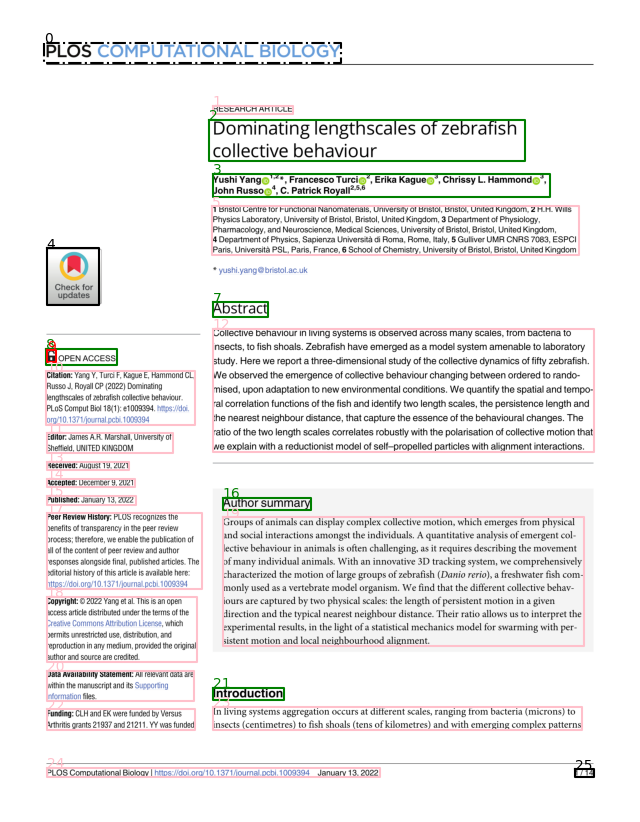

In [5]:
page = 1

images = convert_from_path(path)
p0 = np.array(images[page - 1])
plt.figure(figsize=(8, 14))

for i, el in enumerate(elements):
    if el.metadata.page_number == page:
        coord = el.metadata.coordinates.points
        rect = np.array(list(coord) + [coord[0]])
        if el.category == "Image":
            plt.plot(*rect.T, color="red", ls='-')
            plt.text(*rect[0], i, color="red")
        if el.category == "Title":
            plt.plot(*rect.T, color="green", ls='-')
            plt.text(*rect[0], i, color="green")
        if el.category == "Formula":
            plt.plot(*rect.T, color="navy", ls='-')
            plt.text(*rect[0], i, color="navy")
        if el.category == "Header":
            plt.plot(*rect.T, color="k", ls='-.')
            plt.text(*rect[0], i, color="k")
        if el.category == "FigureCaption":
            plt.plot(*rect.T, color="teal", ls='-')
            plt.text(*rect[0], i, color="teal")
        if el.category == "NarrativeText":
            plt.plot(*rect.T, color="pink", ls='-')
            plt.text(*rect[0], i, color="pink")
        if el.category == "UncategorizedText":
            plt.plot(*rect.T, color="k", ls='-')
            plt.text(*rect[0], i, color="k")

plt.imshow(p0)
plt.axis('off')
plt.show()

## Figure Captions

The figure Captiosn detections are pretty good.

In [6]:
fig_captions = [el for el in elements if el.category == "FigureCaption"]
fig_captions_short = []
for fc in fig_captions:
    content = fc.to_dict()
    content['text'] = content['text'][:50]
    fig_captions_short.append(content)
    
pprint(fig_captions_short, depth=2)

[{'element_id': 'e674fd54a357f28918df3d96a918a520',
  'metadata': {...},
  'text': 'Fig 1. Experimental setup and overall spatial dist',
  'type': 'FigureCaption'},
 {'element_id': '886f8b103dd3640cbc6aca697fcd408e',
  'metadata': {...},
  'text': 'Fig 2. The behavioural quantities of 50 young zebr',
  'type': 'FigureCaption'},
 {'element_id': 'a88202b19a92ea77974c2fd46eefe591',
  'metadata': {...},
  'text': 'https://doi.org/10.1371/journal.pcbi.1009394.g002',
  'type': 'FigureCaption'},
 {'element_id': '3aa7ec78ebbfe167b26076dd6ad69688',
  'metadata': {...},
  'text': 'Table 1. A summary of the variables used to descri',
  'type': 'FigureCaption'},
 {'element_id': '1a70bfc2f7a763b90dcb24d8e5144c4a',
  'metadata': {...},
  'text': 'Fig 3. The states of Zebrafish characterised by tw',
  'type': 'FigureCaption'},
 {'element_id': '33d10e4c689bc8f73c39daefd14fe41f',
  'metadata': {...},
  'text': 'Fig 4. Single–parameter description of the Zebrafi',
  'type': 'FigureCaption'}]


## Use LLM to Filter Chunks

The narrative text (pink) elements are wrong sometimes, including bits that are note from the main text of the paper.

We can use LLM to fix it.

In [7]:
import ollama

command = """\
Is the following text a part from a academic paper that discuss about science?
Or maybe it is something auxiliary about author, funding, reference, institution, addresses, etc?
Respond YES only if the text is from the main text part in a scientific journal article.
Respond NO if the text is about author information, funding sources, institution addresss.
Respond NO if the text is from the reference section.
Respond NO if the text is about data availability.
Respond NO if the text is about the article/letter category..
Respond NO if the text is a url link.
Respond NO if the text is about journal or publication detail like issues, volumes or page number.
Do not respond with anything other than YES NO.

---
{text}
---
"""

def check(text):
    response = ollama.chat(model='gemma2', messages=[
      {
        'role': 'user',
        'content': command.format(text=text)
      },
    ])
    return response['message']['content'].strip() == "YES"

The rectangular shapes with dashed lines are filted out by LLM. 

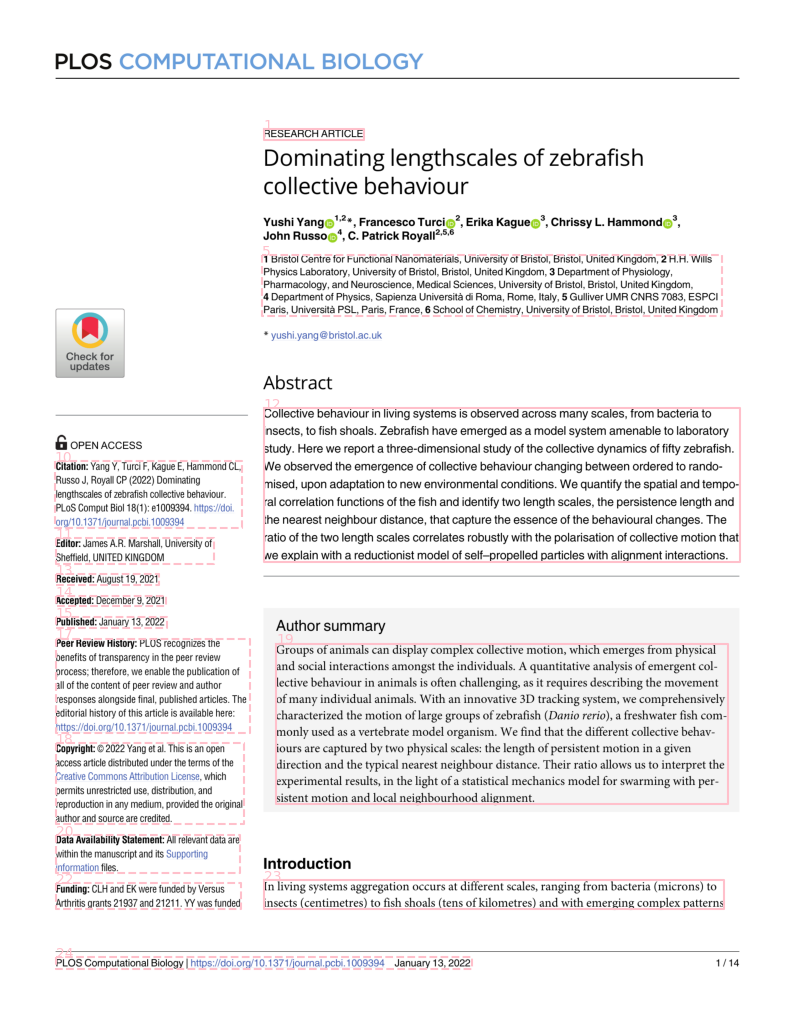

In [8]:
page = 1

images = convert_from_path(path)
p0 = np.array(images[page - 1])
plt.figure(figsize=(10, 18))

for i, el in enumerate(elements):
    if el.metadata.page_number == page:
        coord = el.metadata.coordinates.points
        rect = np.array(list(coord) + [coord[0]])
        
        if el.category == "NarrativeText":
            if check(el.text):
                plt.plot(*rect.T, color="pink", ls='-')
                plt.text(*rect[0], i, color="pink")
            else:
                plt.plot(*rect.T, color="pink", ls='--')
                plt.text(*rect[0], i, color="pink")
plt.imshow(p0)
plt.axis('off')
plt.show()

## Summarize a Paper

This is a little fun thing we can do:

1. extract all text chunks from a paper and concatenate them.
2. extract all figure captions
3. ask an LLM to summarize it!

In [9]:
from tqdm import tqdm
from markdown2 import markdown
from IPython.core.display import HTML

corpus = ""
figure = ""
for i, el in tqdm(enumerate(elements)):
    if el.category == "NarrativeText":
        if check(el.text):
            corpus += el.text
    if el.category == "FigureCaption":
        figure += el.text + "\n"

403it [00:20, 20.03it/s] 


### Paper Summary

In [12]:
command = """\
Please summarise the paper for me.

This is the main text:
---
{corpus}
---

These are the figure captions:
---
{figure}
---

Please generate your summary in the format of markdown note.
Do not include a title in your summary.
"""

summary = ollama.chat(model='gemma2', messages=[
  {
    'role': 'user',
    'content': command.format(corpus=corpus, figure=figure)
  },
])['message']['content'].strip()

HTML(markdown(summary))

### Chinese

In [15]:
command = """\
请帮我总结这一篇论文

文章的正文如下
---
{corpus}
---
文章的图片描述如下
---
{figure}
---

请简单描述文章的亮点，目的，实验方法，实验结果，以及结果的意义。
请用 markdown 格式呈现你的总结。除了专业词汇，请尽量使用中文。
不要在总结中添加题目或者章节标记。
"""

summary = ollama.chat(model='gemma2', messages=[
  {
    'role': 'user',
    'content': command.format(corpus=corpus, figure=figure)
  },
])['message']['content'].strip()

HTML(markdown(summary))